In [ ]:
"""
Seizure Prediction from intracranial EEG
DACO 2020/2021

This file reads all the data from the training and test set.

@authors: Ana Maria Sousa, Mariana Xavier, Rui Santos
"""

import os
import scipy.io
import numpy as np
from scipy.fft import rfft

# Run the training dir.
for dirname, _, filenames in os.walk('/content/drive/MyDrive/train'):
       
  # Read each of the files.
  for filename in filenames:
      print(filename)
      
      # Load the data from each file.
      data = scipy.io.loadmat(os.path.join(dirname, filename))
           
      # Get the field corresponding to the segments.
      train_data = data.get(list(data.keys())[3])
            
      # Get in a separate array the values of EEG for the different channels.
      data = train_data['data'][0][0]
    
      # Considering all the different channels as representative of the EEG.
      for channel in range (data.shape[0]):
          # guardar ficheiros na drive em formato .npy
          np.save('/content/drive/MyDrive/fft/' + filename[:len(filename)-4] + '_channel_' + str(channel) + '.npy',abs(rfft(data[channel])))


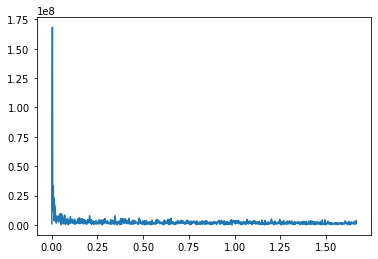

In [5]:
import numpy as np
from scipy.fft import rfftfreq
import matplotlib.pyplot as plt

arr = np.load('/content/drive/MyDrive/fft/Patient_1_interictal_segment_0001_channel_0.npy') # como ler os ficheiros
freq = rfftfreq(3000000,1/5000)

plt.figure()
plt.plot(freq[:1000],arr[:1000])
plt.show()


In [75]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(1500001,64)
    self.fc2 = nn.Linear(64,64)
    self.fc3 = nn.Linear(64,64)
    self.fc4 = nn.Linear(64,2)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x),dim=0)

    return x

net = Net()
net = net.double()

In [ ]:
import os
import random
import numpy as np
import torch.optim as optim
import torch.tensor as tensor
import torch

optimizer = optim.Adam(net.parameters(),lr=0.001)

filenames = [line[2] for line in os.walk('/content/drive/MyDrive/fft')][0]

batch_size = 10
epochs = 1

for epoch in range(epochs):

  random.shuffle(filenames)
  batches = [filenames[i:i+batch_size] for i in range(0,len(filenames),batch_size)]

  for batch in batches:

    y = tensor([int('preictal' in i) for i in batch])
    x = [tensor(np.load('/content/drive/MyDrive/fft/' + file)) for file in batch]
    x = torch.stack(x)
    
    
    net.zero_grad()
    output = net(x)
    print(output)
    loss = F.nll_loss(output,y)
    loss.backward()
    optimizer.step()
    print(loss)